In [36]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft, ifft
import sounddevice as sd
from scipy.signal.windows import hann

### 1. Frequency modulation sound synthesis (0.5 points)

In [57]:
fs = 16000   # Sampling rate
fc = 880     # Carrier frequency
fmod = 220   # Modulation frequency
amplitude = 1
I = 2        # Modulation index
duration = 1 # number of samples in signal

#### Create the signal, plot it and also its DFT spetrum

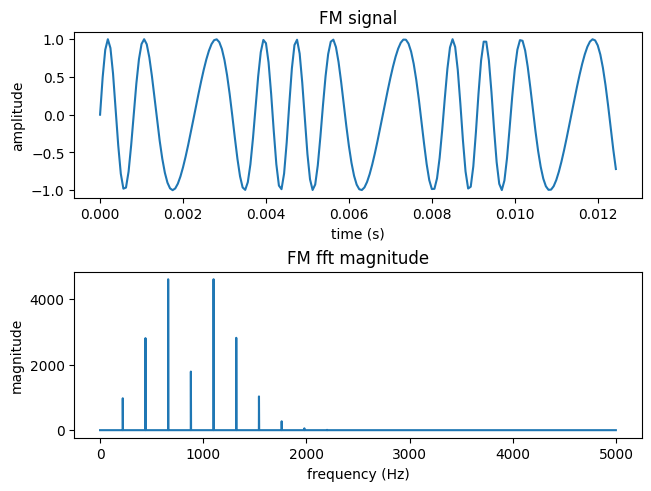

In [58]:
# The FM modulated signal
t = np.arange(0.0, duration, duration/fs)
n = fs*duration
mod_sig = amplitude*np.sin(2*np.pi*t*fmod)
# carr_sig = amplitude*np.sin(2*np.pi*t*fc)
FM = amplitude*np.sin(2*np.pi*fc*t + I*mod_sig)

# Plot
fig, ax = plt.subplots(2, layout="constrained")
ax[0].plot(t[:200], FM[:200])
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("amplitude")
ax[0].set_title("FM signal")

# Compute DFT and plot it
fft_FM = fft(FM, n)
fft_mag_FM = np.abs(fft_FM)
ax[1].plot(fft_mag_FM[:5000])
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("magnitude")
ax[1].set_title("FM fft magnitude")
plt.show()

#### Play the sound

In [59]:
sd.play(FM)

#### Auxiliary functions

In [68]:
def princarg(phase_in):
    """
    Computes principle argument,  wraps phase to (-pi, pi]
    """
    phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi;
    return phase
  

def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    
    return delta_phi

### 2. Implement a time stretching algorithm using phase vocoder. (1.5 points)

In [71]:
audioIn, fs = lb.load('audio.wav', sr=None)   # read audio

wLen = int(0.032*fs)                   # window length
winAn = np.sqrt(hann(wLen, sym=False)) # analysis window
winHopAn = int(0.008*fs)             # Hop length or frame advance
inInd = 0
winSyn = winAn

R = 1.4 #winHopSyn / winHopAn;
winHopSyn = int(R * winHopAn)
prev_frame = None
outInd = 0

audioOut = np.zeros(int(len(audioIn)*R))      # placeholder for reconstructed audio

while inInd< len(audioIn)-wLen:
    # selct the frame and multiply with window function
    frame = audioIn[inInd:inInd+wLen]* winAn 
    
    # compute DFT
    f = fft(frame)

    # save magnitudes and phases
    mag_f = np.abs(f)
    phi0 = np.angle(f) 

    ####################
    # processing in spectral domain 
    #######################
    
    # Calculate phase difference between two consecutive frames
    delta_phi = None
    prev_frame_angle = None
    if (prev_frame is None):
        prev_frame_angle = np.zeros(wLen)
    else:
        prev_frame_angle = np.angle(prev_frame)
    delta_phi = delta_phi_(phi0, prev_frame_angle, winHopAn, wLen)
    
    # Update previous frame
    prev_frame = frame

    # Update phase for current frame
    # Synthesis phase = prev_frame_angle + R * delta_phi
    # The reason why we need to scale the delta_phi is because we want to stretch the signal to R times
    phi0 = prev_frame_angle + R * delta_phi
    
    # wrap synthesis phase between (-pi; pi]
    phi0 = princarg(phi0)
    
    # Recover the complex FFT back
    ft = (mag_f * np.exp(1j*phi0))  

    # inverse DFT and windowing
    frame = np.real(ifft(ft))*winSyn

    # Ovelap add
    audioOut[outInd :outInd +wLen] =  audioOut[outInd :outInd +wLen] + frame

    # frame advance by winHopAn
    inInd = inInd + winHopAn
    outInd = outInd + winHopSyn

In [77]:
sd.play(audioIn, fs)

In [78]:
sd.play(audioOut, fs)

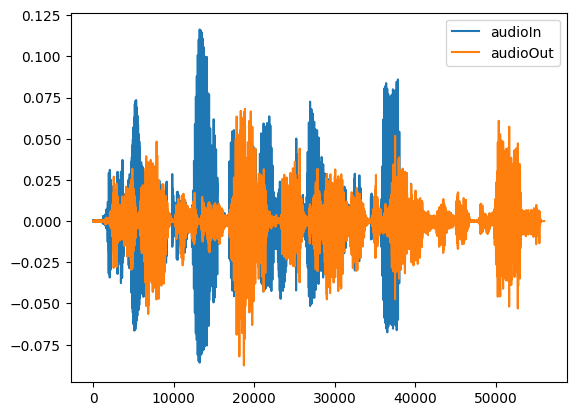

In [79]:
plt.plot(audioIn)
plt.plot(audioOut)
plt.legend(["audioIn","audioOut"])

### Bonus question: Add pitch shifting